# Transfer Learning from Inception Model
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
In the previous notebook we have seen how long it takes to process a CNN for image recognition, even using $TensorFlow$, that is efficient enough compared to other tools, and very small pictures. Also the results are good for the dataset we've used, but not outstanding. 
The advantage of using Neural Networks in general is that, even if it takes long to train, the Network itself can be loaded and used offline with not much effort. The intuition here is to use a pre-trained CNN and transfer part of it to build a new classifier (in this case based on CIFAR-10 to make a comparison). 

## Inception Model
The Inception v3 model is a CNN by Google that takes weeks to train on a computer with 8 Tesla K40 GPUs and is impossible to train it on an ordinary PC. We will instead download the pre-trained Inception model and use it to classify images and then as a base to build the CIFAR-10 classifier we've seen in the previous notebook to then compare results. The advantages of Neural Networks are pretty much clear in this model that takes ages to train on a regular PC, but only a moment to use. 
The following picture shows the architecture of the model.

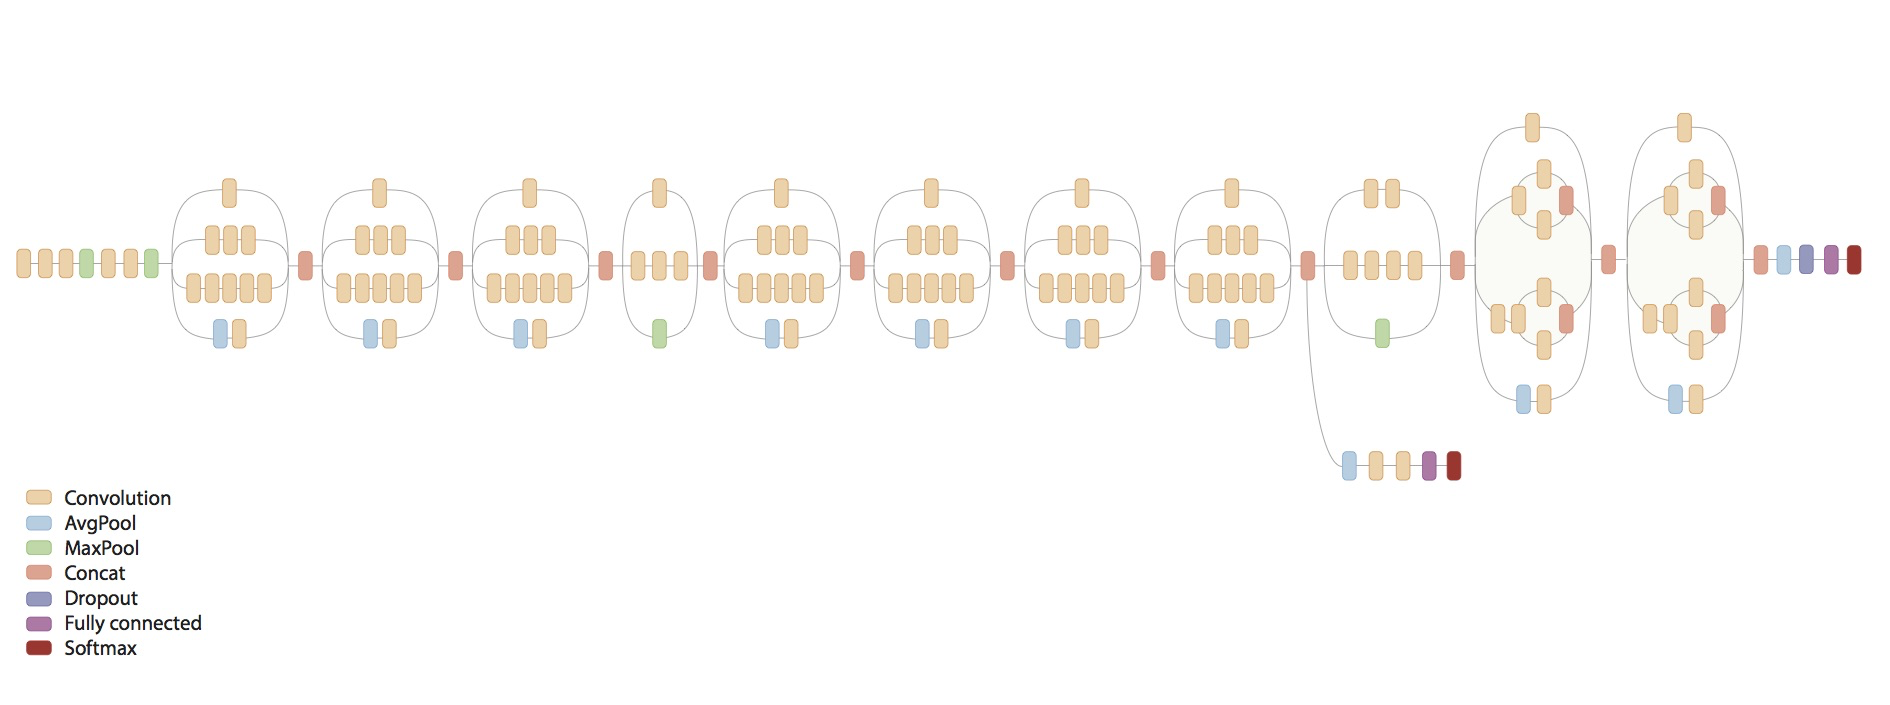

In [1]:
from IPython.display import Image, display
Image('images/04_inceptionV3Architecture.png')

The chart shows that Inception V3 is a Convolutional Neural Network with many layers and a very complicated structure. The two softmax layers are used during training and only the left one is used for classification. This is done in order to fight the vanishing gradient problem in very deep networks, a problem that we've partially experienced in the last notebook (the second convolutional layer had a much lower standard deviation compared to the first one). To avoid overfitting they use a regularization parameter, and they also admit in the research paper that they don't fully understand why Inception V3 works, but it actually outperforms every state of the art model before its release, and by a substantial margin.

It is trained using **ImageNet**, a common academic data set in machine learning for training an image recognition system, but with much higher resolution image compared to CIFAR-10, so it would require a lot of time to train. 

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Functions and classes for loading and using the Inception model.
import inception

tf.__version__

'0.9.0'

Now that the library is imported we can load the data from the CNN.

In [3]:
inception.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


## Image classification with Inception V3
The download of the Inception model also includes an example image, and a very low resolution one, to test if everything worked fine. We're going to use it to provide an example of classification.

In [5]:
# Load the Inception model so it is ready for classifying images.
model = inception.Inception()
# Helper-function for classifying and plotting images
def classify(image_path):
    display(Image(image_path))
    pred = model.classify(image_path=image_path)
    model.print_scores(pred=pred, k=10, only_first_name=True)
# Image path for the example picture to classify
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')

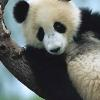

89.23% : giant panda
 0.86% : indri
 0.26% : lesser panda
 0.14% : custard apple
 0.11% : earthstar
 0.08% : sea urchin
 0.05% : forklift
 0.05% : soccer ball
 0.05% : go-kart
 0.05% : digital watch


In [6]:
classify(image_path)

### Reading the results
The result of the classify function is the same softmax layer we've seen in the previous notebook, with basically probabilities from 0 to 1, but this time over 1000 classes. In this case the model is pretty sure (almost 90%) that the image contains a panda. 
However sometimes the model is less sure about the result, but it's still interesting to see the various scores in the softmax layer, because it may offer a description of multimple objects contained in the image, as shown in the following examples. 

### More examples
The following examples are produced using images found on Google and specifically not from ImageNet, so not from the training set.

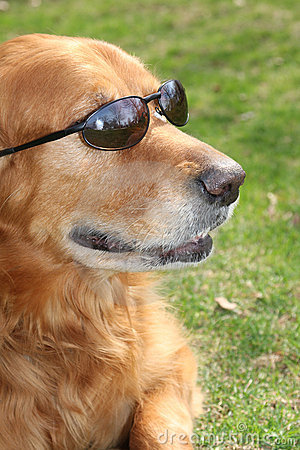

46.54% : golden retriever
16.03% : sunglass
12.33% : sunglasses
 4.01% : Pembroke
 1.04% : cocker spaniel
 0.92% : Cardigan
 0.78% : collie
 0.66% : Irish setter
 0.64% : Norfolk terrier
 0.41% : Pekinese


In [9]:
classify(image_path="imagesForClassification/dogWithSunglasses_1.jpg")

This example is outstanding. We've looked for a very uncommon picture to see how Inception V3 behaves and not only the classifier detects it's a golden retriever, so the specific breed of the dog, but also, with a cumulative 28%, that the picture contains sunglasses or dark glasses (for some reason the Inception model has been trained to recognize two very similar classes for sunglasses). 

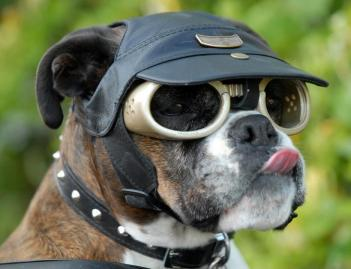

45.65% : muzzle
20.92% : boxer
10.58% : Boston bull
 1.41% : sunglass
 1.32% : Greater Swiss Mountain dog
 1.30% : sunglasses
 1.17% : Great Dane
 1.17% : Saint Bernard
 1.10% : bull mastiff
 0.77% : American Staffordshire terrier


In [10]:
classify(image_path="imagesForClassification/dogWithSunglasses_2.png")

Here the model detects multiple things in this very uncommon picture, some are right, some are wrong. First of all it thinks that it contains a muzzle, while it's actually a hat, pretty uncommon on a dog. Also overall there is a 35% chance this is a dog, but split in multiple breeds across the classes (with almost 21% bet on the Boston bull, which is true). Another interesting fact is that it detects the sunglasses, giving it 1.41% in the sunglass class and 1.3% in the sunglasses class. 

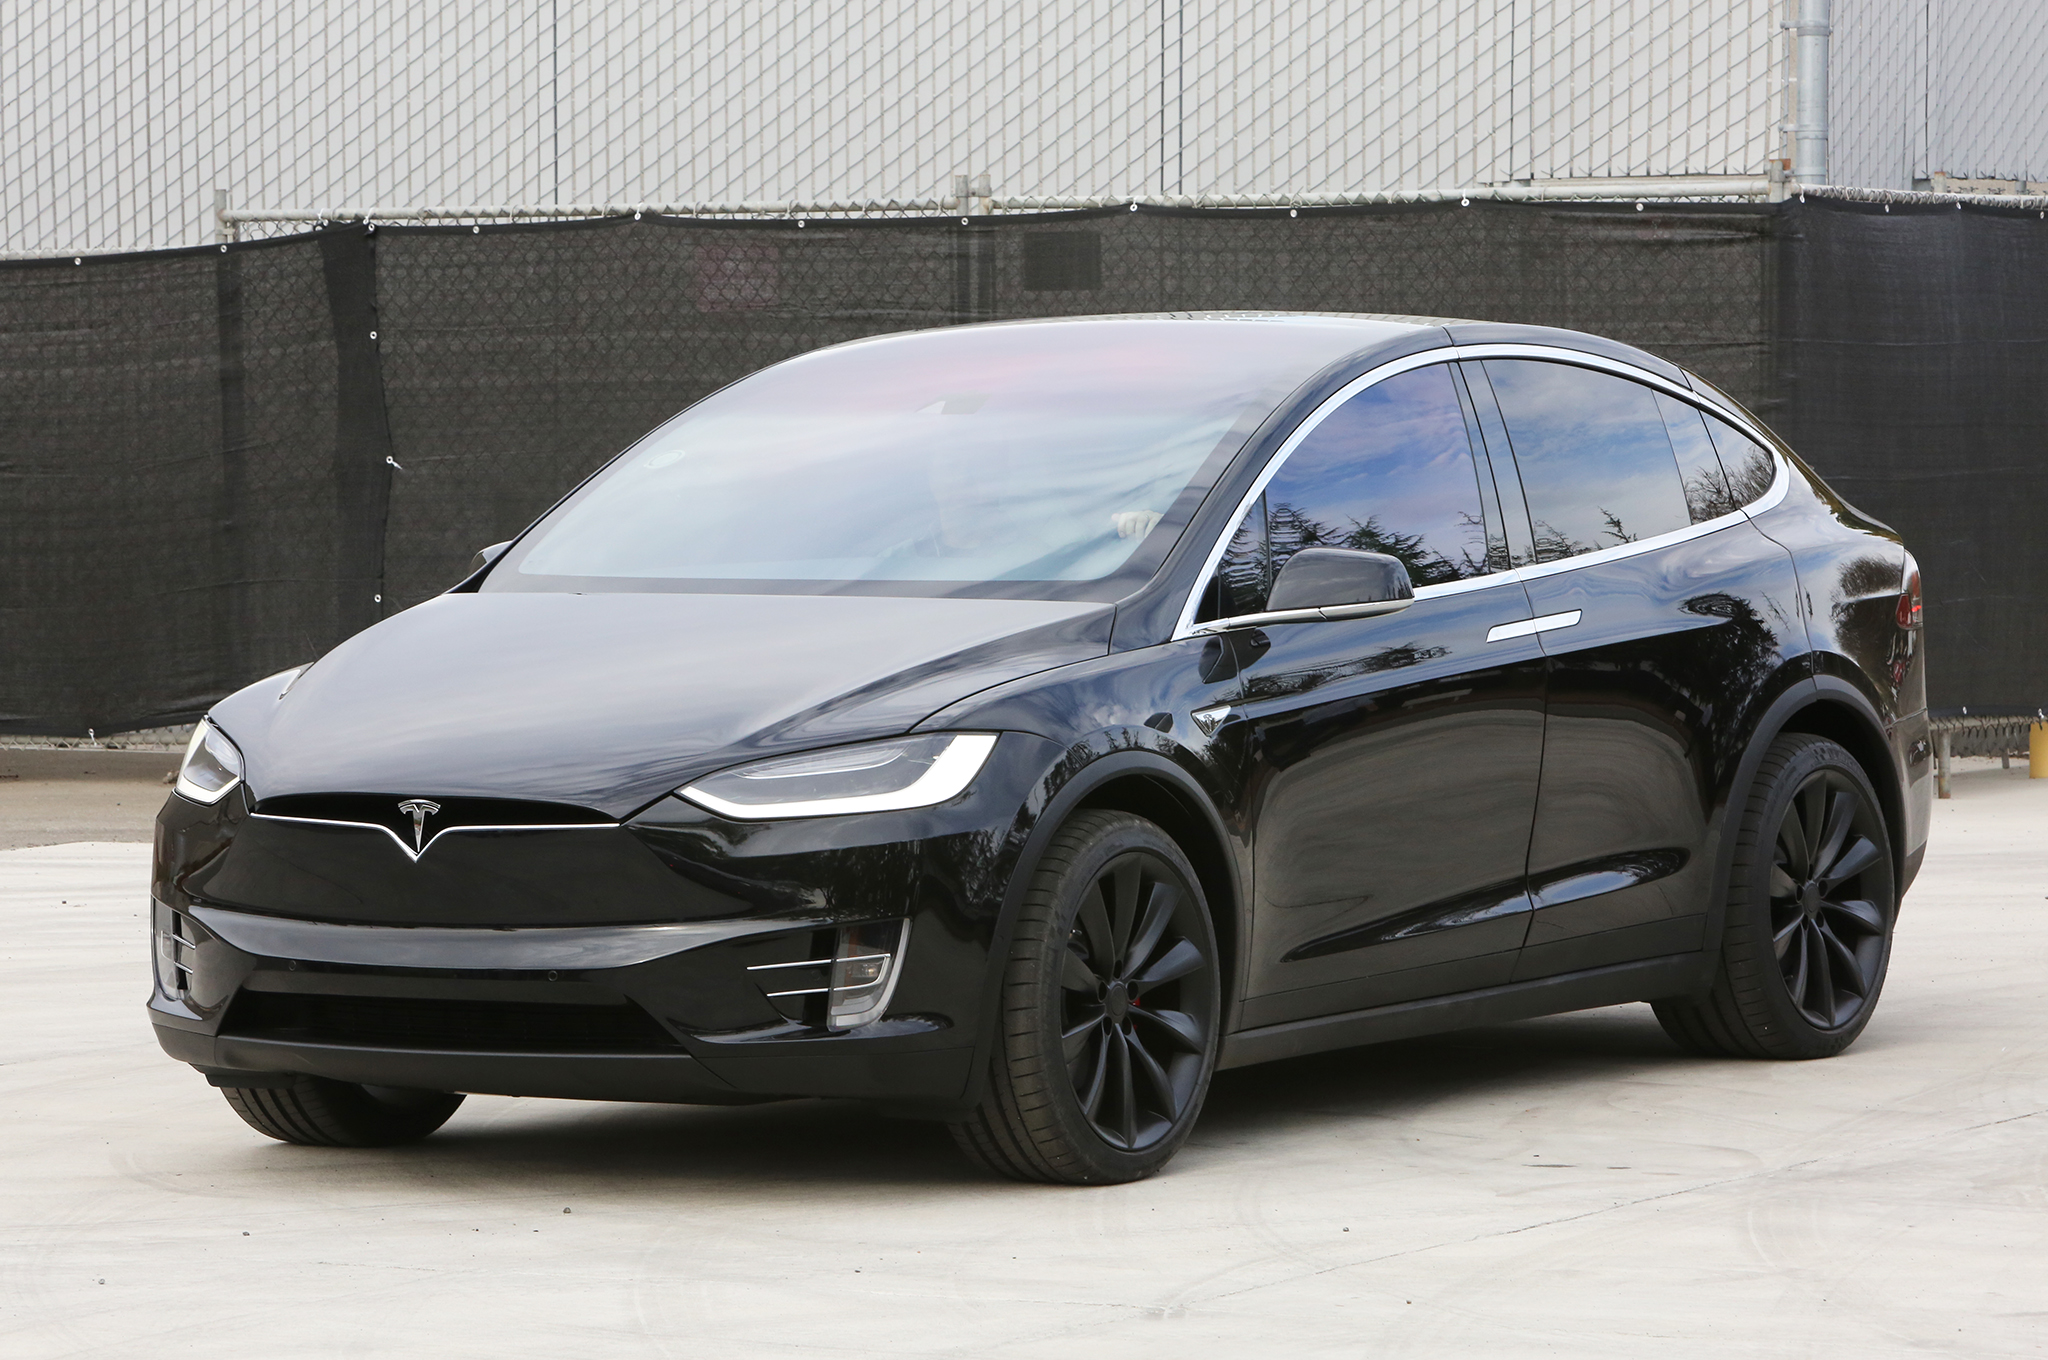

31.58% : beach wagon
17.37% : car wheel
15.57% : sports car
 9.04% : grille
 3.59% : convertible
 2.41% : minivan
 1.77% : limousine
 1.03% : racer
 0.44% : solar dish
 0.31% : cab


In [14]:
classify(image_path="imagesForClassification/tesla.jpg")

This last examples shows how well the model behaves on unanimated objects and overall objects similar to the one used during training. This one in particular is a very new car model, so it's not on ImageNet, however sport cars are very similar, so the model behaves pretty well. 

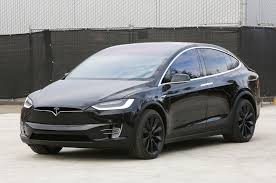

27.83% : sports car
18.11% : car wheel
 9.60% : beach wagon
 7.41% : grille
 4.87% : limousine
 3.42% : racer
 2.93% : pickup
 2.03% : minivan
 1.52% : convertible
 0.77% : car mirror


In [15]:
classify(image_path="imagesForClassification/tesla_resized.jpg")

Finally this one is a resized version of the previous image, almost 16 times smaller, and we can see how the model gives the same top 3 results. This will be important in the final notebook about adversary examples and solutions, where we'll see how CNNs behave when white noise is involved. 

## Transfer Learning
The goal is to re-use the pre-trained Inception model and replace the layer that does the final classification. This is called **Transfer Learning**, since we're not training the CNN from scratch or random values, but from a previous training, at least of the convolutional part. We're still going to train our classifier, but starting from features extracted by a very capable network. 

The goal is to produce a CNN that takes less time to train and is more accurate then the previous one, using the same CIFAR-10 dataset. 